In [1]:
import nbsetup
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt
from models.sparc.dataframe import load_analysis
from models.equations import velocity, null_gravity

In [2]:
full_df = load_analysis()

In [3]:
filter_bad_simulation = full_df.query("Vbul==0.0").query("rel_R>0.1").query("rel_R<0.9")
filter_bad_quality = filter_bad_simulation.query("Q<3").query("Inc<80").query("Inc>30")
datasets = [full_df, filter_bad_simulation, filter_bad_quality, full_df.query('VWdiff<0.2'), full_df.query('VWdiff<0.5')]

In [11]:
def curve_fit_entiredataset(df):
    
    def func(r, gamma, alpha):
        return velocity(r, null_gravity(df['Fnewton'], df['Fnulled'], gamma, alpha))
    
    ndf = df.copy()
    R = ndf['R']
    args, pcov = sp.optimize.curve_fit(func, R, ndf['Vobs'])
    ndf['log_Tgbar'] = np.log10(func(R, *args)**2/R)
    print(args)
    return ndf

In [12]:
fitted = curve_fit_entiredataset(filter_bad_quality)

[19.08280022  0.2792535 ]


In [67]:
def meta_optimise_with_tau(df):

    def func_generator(gen_r, gamma, alpha, epsilon):
            
        # for each galaxy find best tau
        # for a given set of gamma, alpha, epsilon
        # within bounds
        tau_bounds = [0, 10]
        
        # then return the optimised vobs for each galaxy
        velocities = []
        
        for uid, gdf in df.groupby('ID'):
            
            def galaxy_func(inner_r, tau):
                # these values have already been interp
                force = gdf['Fnewton']
                nulled = gdf['Fnulled']
                nforce = force*epsilon*(gamma**((nulled+tau)*alpha))
                return velocity(inner_r, nforce)
            
            galactic_r = gdf['R']
            
            args, pcov = sp.optimize.curve_fit(galaxy_func, galactic_r, gdf['Vobs'], bounds=tau_bounds)
            
            # this should be the same as gen_r in total
            velocities.append(galaxy_func(galactic_r, *args))
        
        return pd.concat(velocities)
    
    
    return sp.optimize.curve_fit(func_generator, df['R'], df['Vobs'])

In [68]:
meta_optimise_with_tau(full_df)

KeyboardInterrupt: 

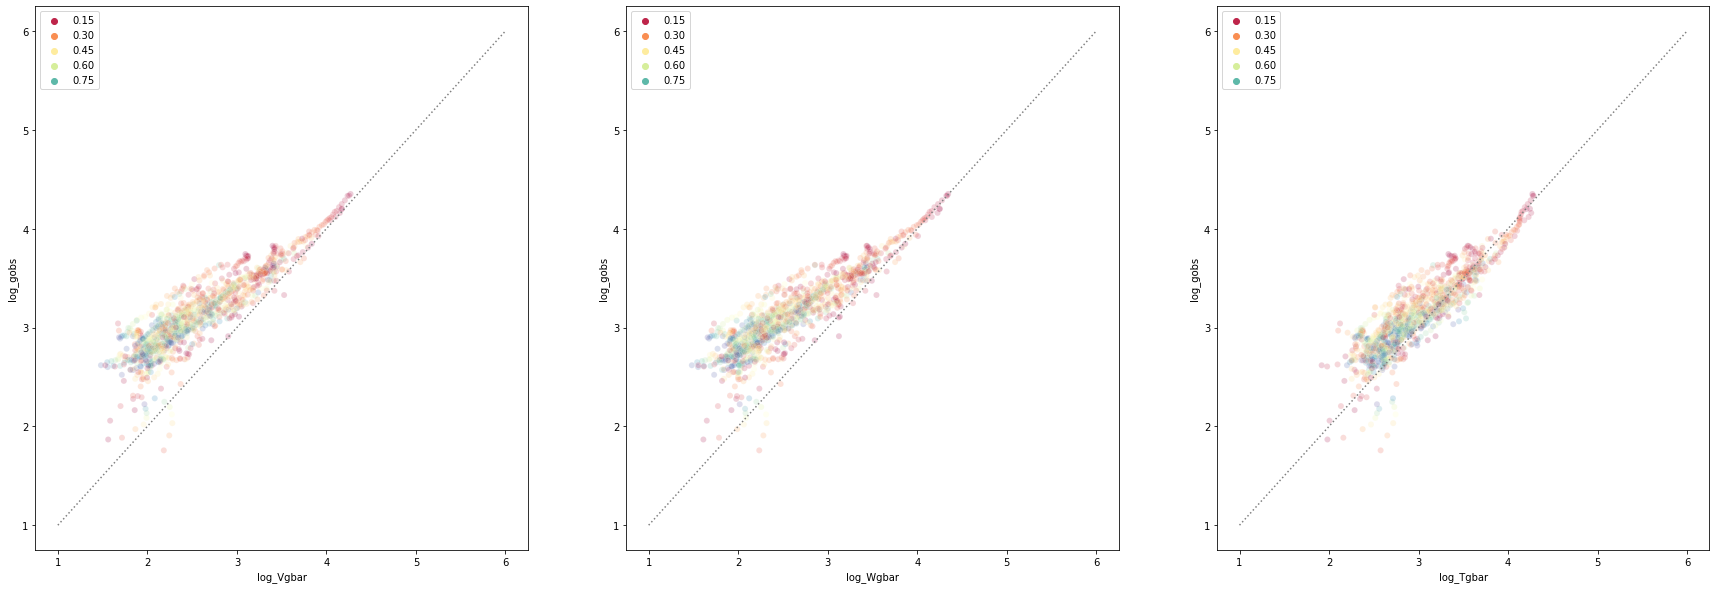

In [13]:
def plot_rar(df):
    fig, axes = plt.subplots(1, 3, figsize=(30,10))
    for i, iden in enumerate(('V', 'W', 'T')):
        g = sns.scatterplot(data=df, x='log_%sgbar' % iden, y='log_gobs', alpha=0.2, hue='rel_R', palette='Spectral', ax=axes[i])
        #g.set(xscale="log", yscale="log")
        
        line = [1,6]
        sns.lineplot(x=line, y=line, color='grey', ax=axes[i], linestyle='dotted')

plot_rar(fitted)#[plot_rar(d) for d in datasets]

[None, None, None]

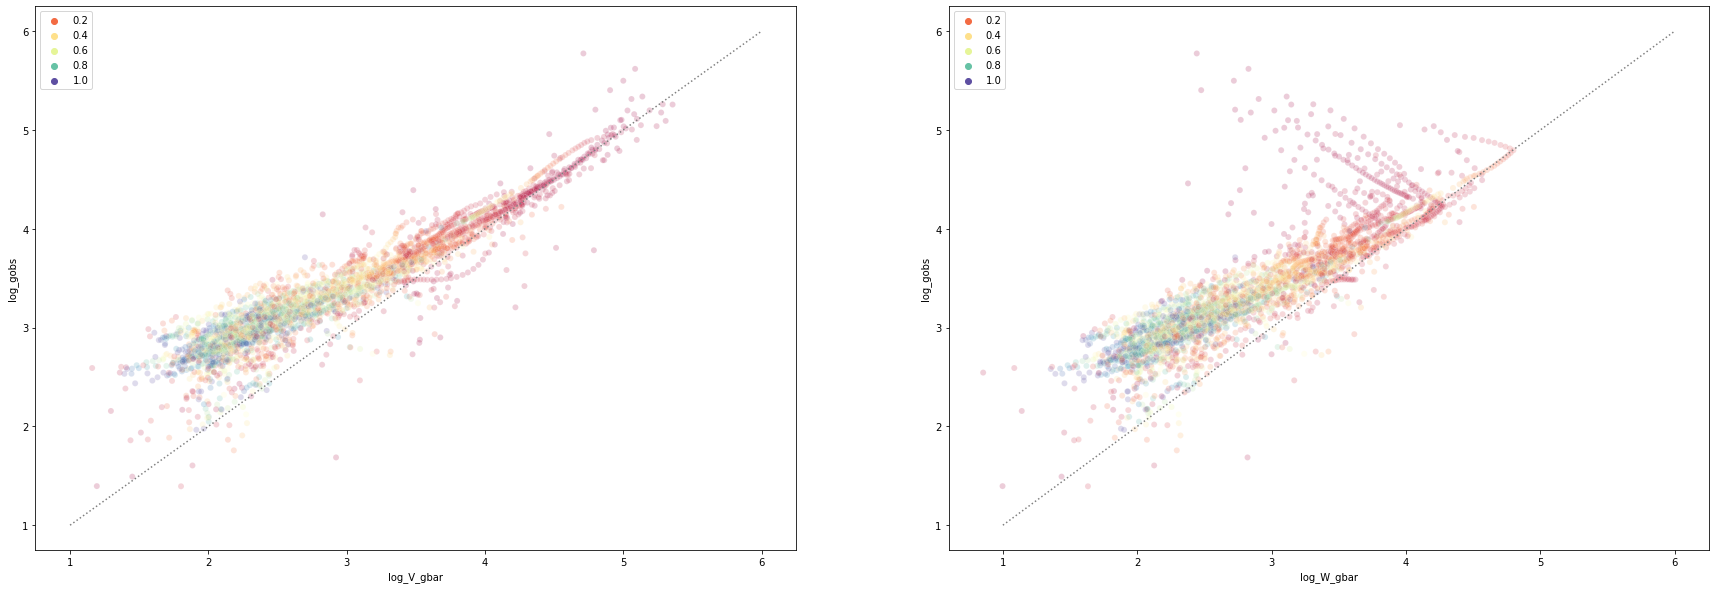

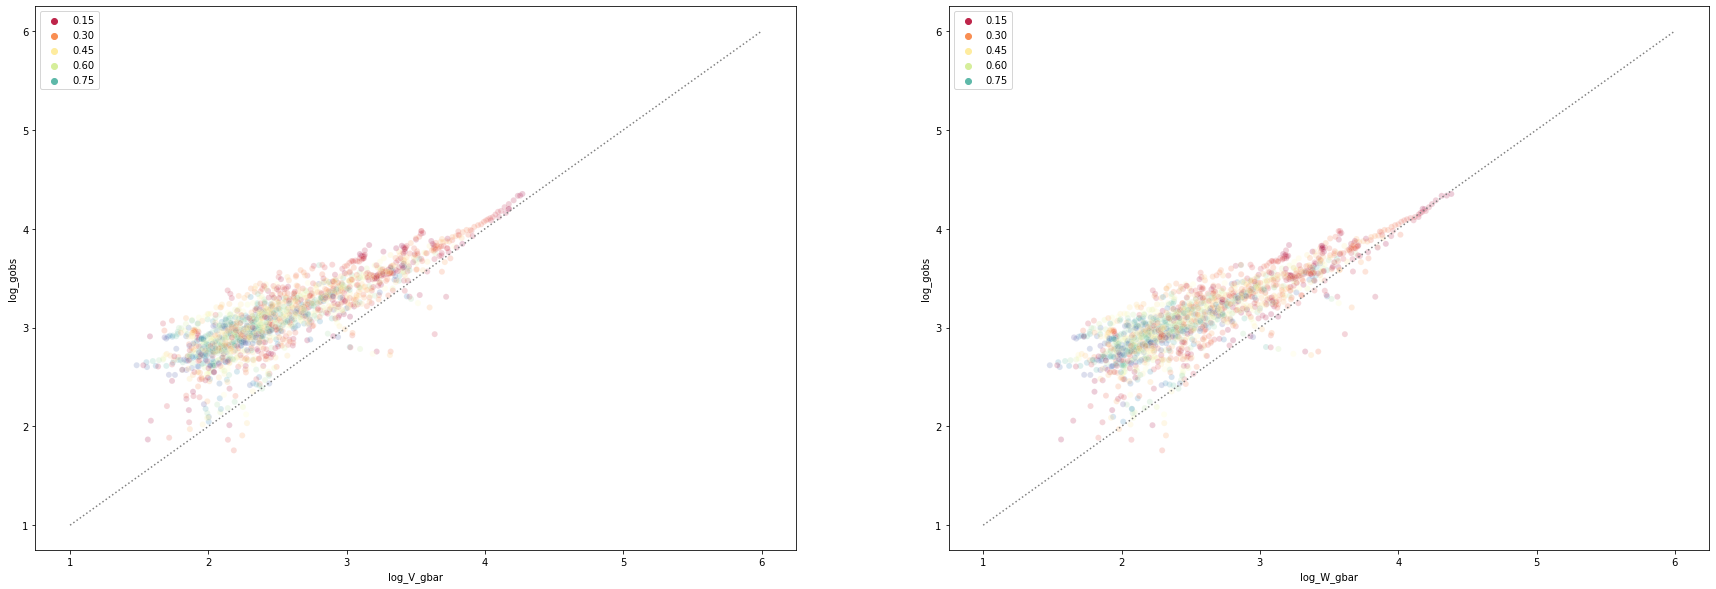

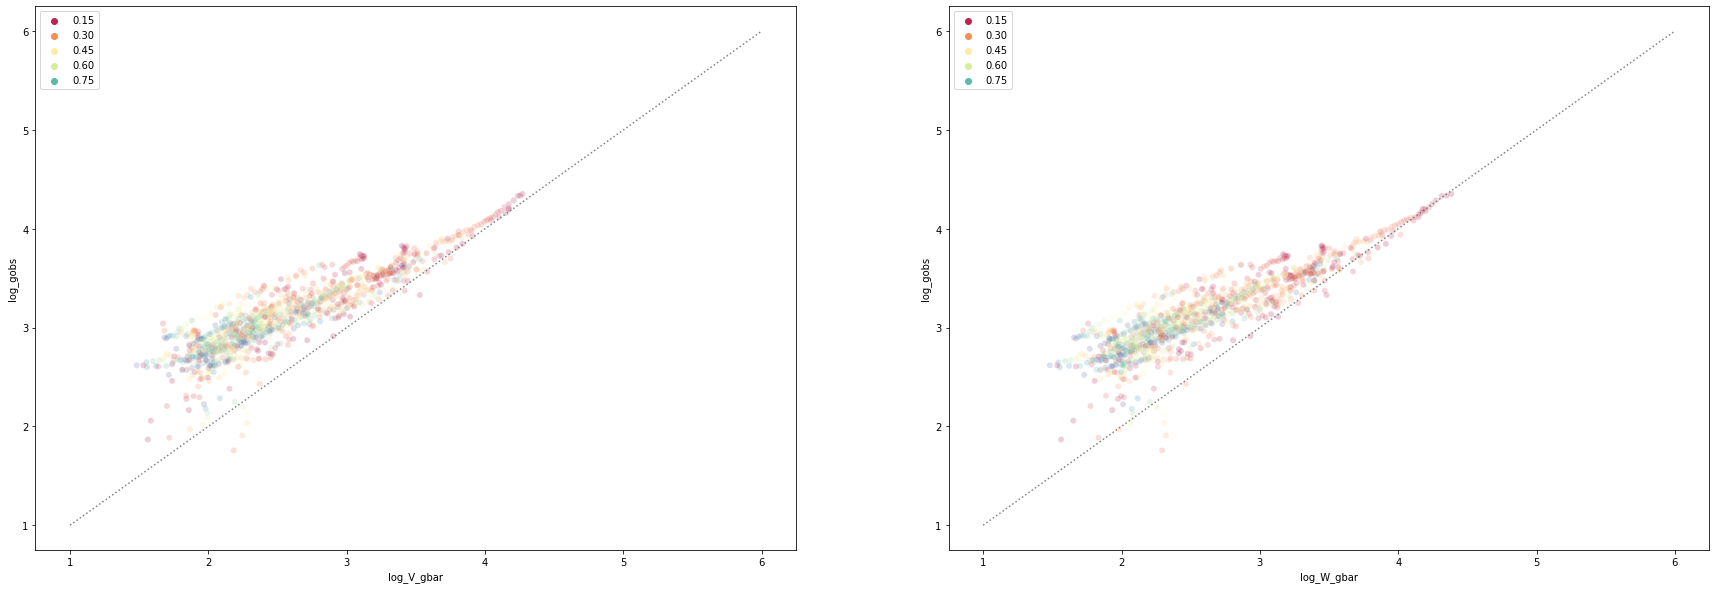

In [12]:
def plot_rar(df):
    fig, axes = plt.subplots(1, 2, figsize=(30,10))
    for i, iden in enumerate(('V', 'W')):
        g = sns.scatterplot(data=df, x='log_%s_gbar' % iden, y='log_gobs', alpha=0.2, hue='rel_R', palette='Spectral', ax=axes[i])
        #g.set(xscale="log", yscale="log")
        
        line = [1,6]
        sns.lineplot(x=line, y=line, color='grey', ax=axes[i], linestyle='dotted')

[plot_rar(d) for d in datasets]

KeyError: 'log(gobs)'

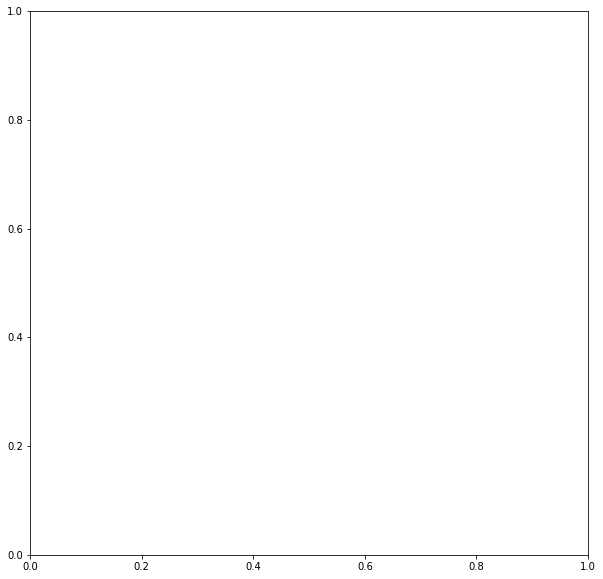

In [35]:
"""
OTHER CANDIDATES

Best so far is force*gamma*(epsilon**(nulled**alpha))
Logisitic function force/(1+e**(nulled**alpha + epsilon))

"""



def nulled_plot(df):
    fig, axes = plt.subplots(1,1, figsize=(10,10))
    x = np.log10(df['Fnulled'])
    y = df['log_gobs']/(1.8*df['log(W_gbar)']/(x**(0.35)))
    sns.scatterplot(data=df, x=x, y=y, color='black', s=10, alpha=0.1)
    sns.histplot(data=df, x=x, y=y, bins=30, pthresh=.1, cmap="mako_r", alpha=0.9)
    result = sp.stats.linregress(x, y)
    sns.lineplot(x=x, y=result.slope*x+result.intercept, color='red').set(ylim=(0,None))
    axes.axhline(y=1, color='orange')
    print(result.intercept, result.slope)
    #sns.regplot(x=x, y=y, order=1, x_bins=20, color='orange')
    

nulled_plot(full_df)

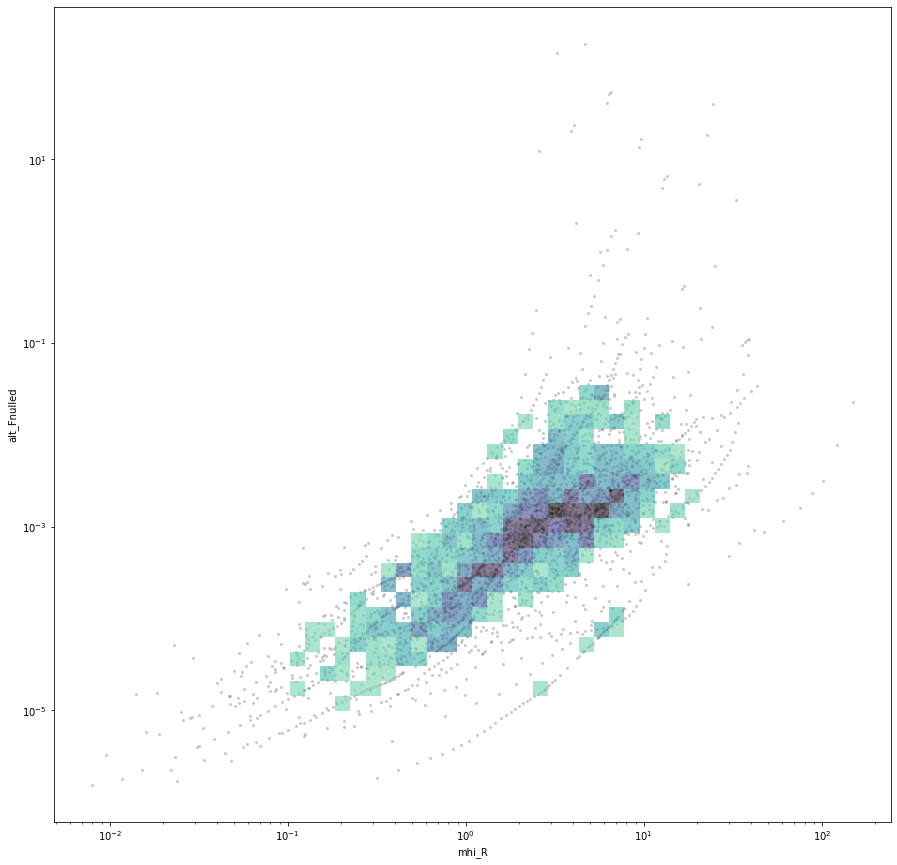

In [62]:
def relationship(df):
    x = 'mhi_R'
    y = 'alt_Fnulled'
    df[y] = (1/df['Fnulled'])
    fig, axes = plt.subplots(1, 1, figsize=(15,15))
    sns.scatterplot(data=df, x=x, y=y, color='black', s=10, alpha=0.2).set(xscale='log', yscale='log')
    sns.histplot(data=df, x=x, y=y, bins=50, pthresh=.2, cmap="mako_r", alpha=0.6)

relationship(full_df)

,check,r2,rslope,rstderr,rintercept
0,rel_R,0.044395,-0.207460,0.024138,1.106353
1,nulled,0.105283,0.089561,0.006548,0.752166
2,mhi_R,0.043373,-0.101027,0.011899,1.057074
3,R,0.131823,-0.182641,0.011755,1.131726
4,D,0.020011,-0.078784,0.013827,1.102178
5,MHI,0.013603,-0.046517,0.009934,1.033237


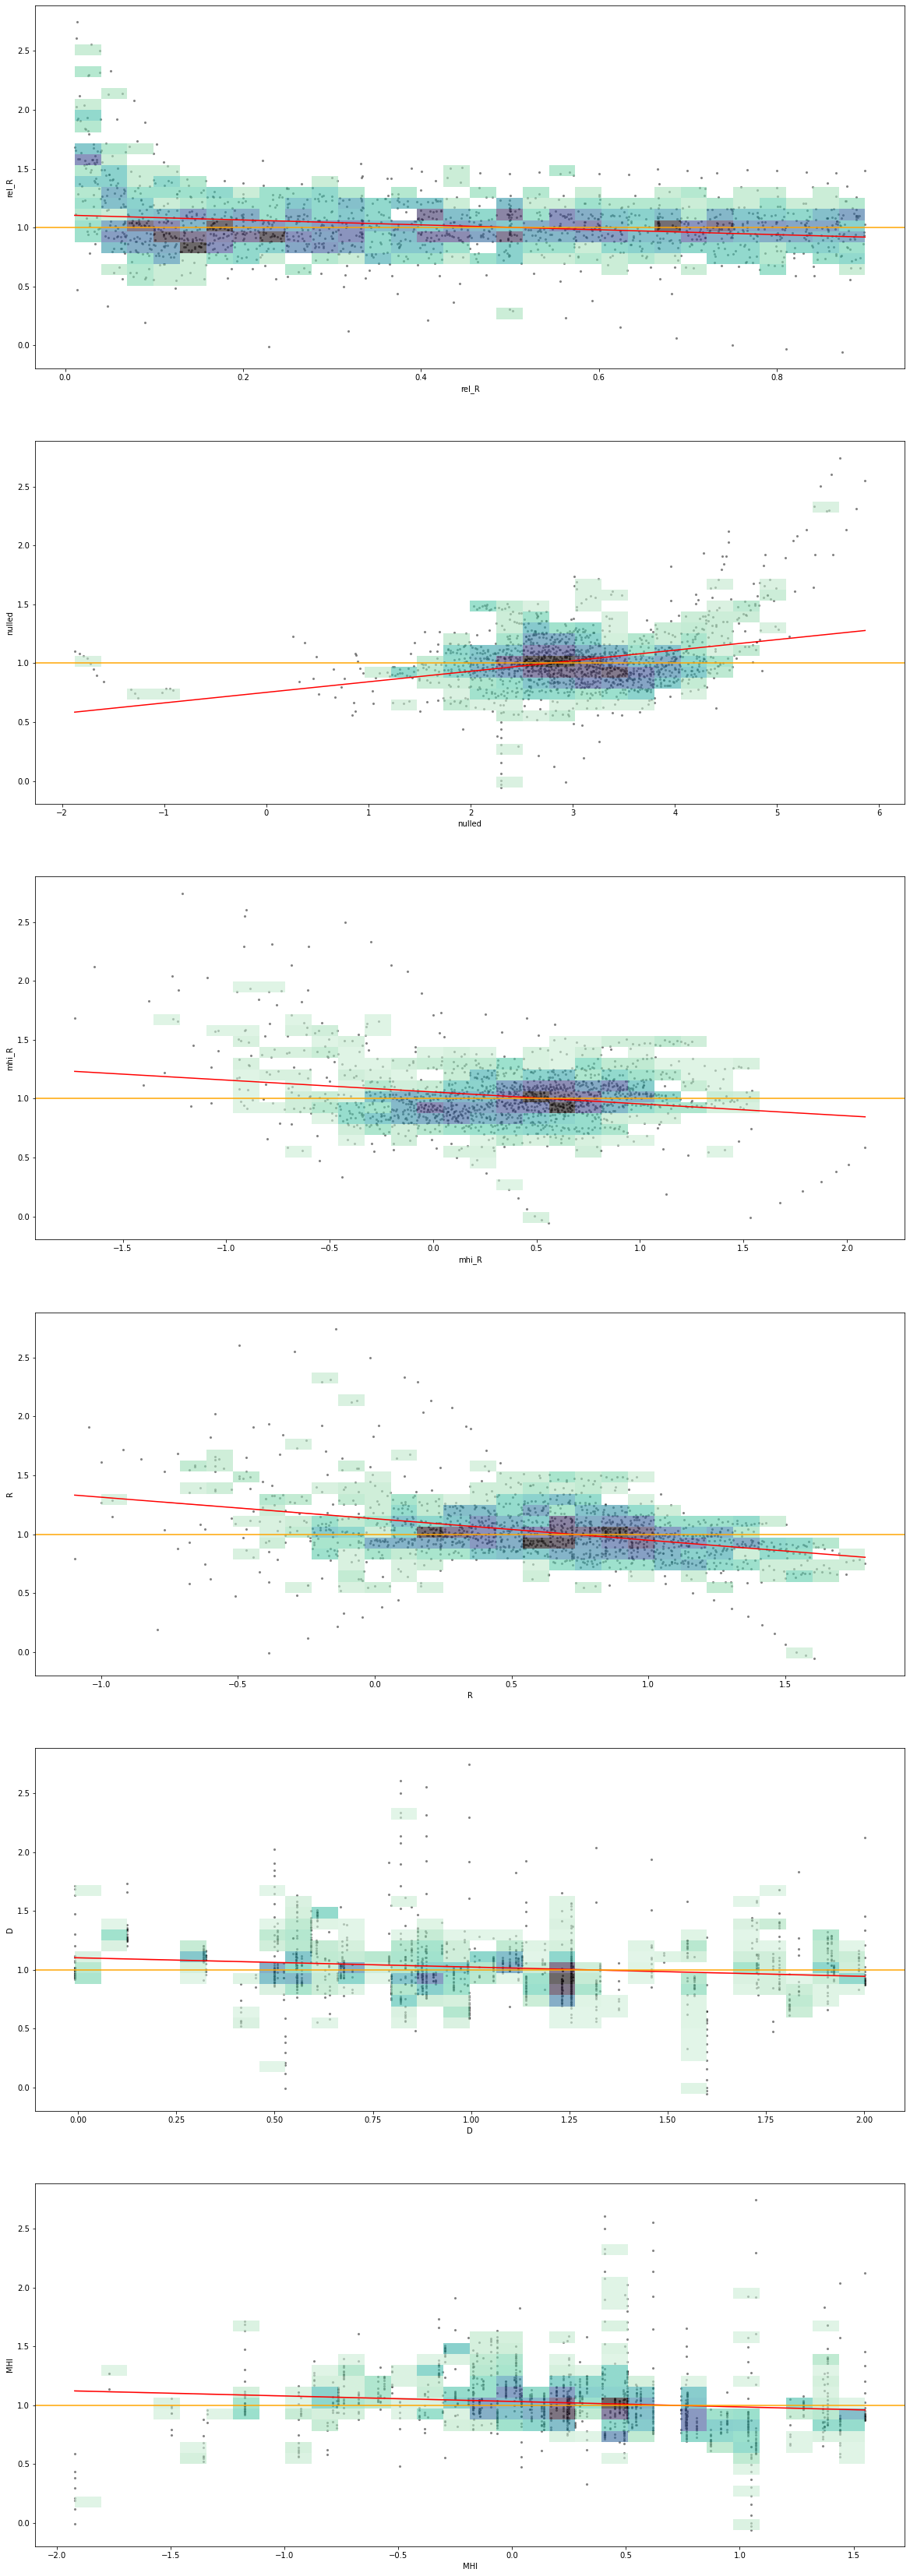

In [24]:
def residual_plots(df, iden='V', checks={'rel_R':1, 'nulled':0, 'mhi_R':0, 'R':0, 'D':0, 'MHI':0}):
    data = []
    fig, axes = plt.subplots(len(checks), 1, figsize=(20,10*len(checks)))
    for i, c in enumerate(checks.keys()):
        if checks[c]:
            x = df[c]
        else:
            x = np.log10(df[c])
        nulled = df['nulled']
        yprime = (1.8*df['W_gbar']*(0.6**(nulled**0.17)))
        #yprime = df['W_gbar']
        #yprime = 
        y = np.log10(df['gobs']/yprime)
        result = sp.stats.linregress(x, y)
        sns.scatterplot(x=x, y=y, color='black', s=10, alpha=0.5, ax=axes[i])
        sns.histplot(x=x, y=y, bins=30, pthresh=.05, cmap="mako_r", alpha=0.6, ax=axes[i])
        sns.lineplot(x=x, y=result.slope*x+result.intercept, color='red', ax=axes[i])
        axes[i].axhline(y=1, color='orange')
        data.append({
            'check': c,
            'r2': result.rvalue**2,
            'rslope': result.slope,
            'rstderr': result.stderr,
            'rintercept': result.intercept
        })
    
    return pd.DataFrame(data)

residual_plots(filtered_df)

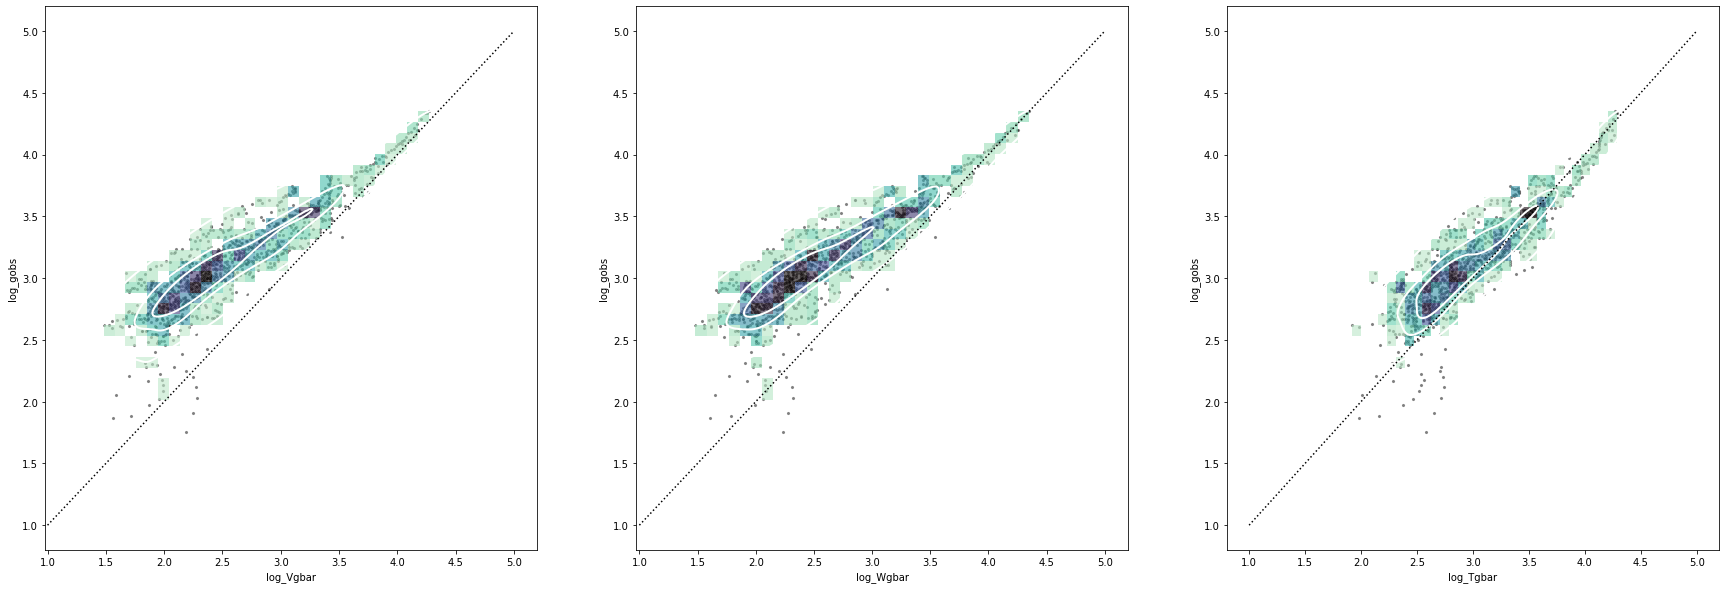

In [14]:
def plot_rar_denity(df, line=[1,5]):
    fig, axes = plt.subplots(1, 3, figsize=(30,10))
    for i, iden in enumerate(('V', 'W','T')):
        x = 'log_%sgbar' % iden
        y = 'log_gobs'
        sns.scatterplot(data=df, x=x, y=y, color='black', s=10, alpha=0.5, ax=axes[i])
        sns.histplot(data=df, x=x, y=y, bins=30, pthresh=.01, cmap="mako_r", ax=axes[i], alpha=0.6)
        sns.kdeplot(data=df, x=x, y=y, levels=4, color="w", linewidths=2, ax=axes[i])
        sns.lineplot(x=line, y=line, color='black', linestyle='dotted', ax=axes[i])
        #sns.regplot(data=df, x=x, y=y, order=1, ax=axes[i], x_bins=10, color='orange')

plot_rar_denity(fitted)#[plot_rar_denity(d) for d in datasets]

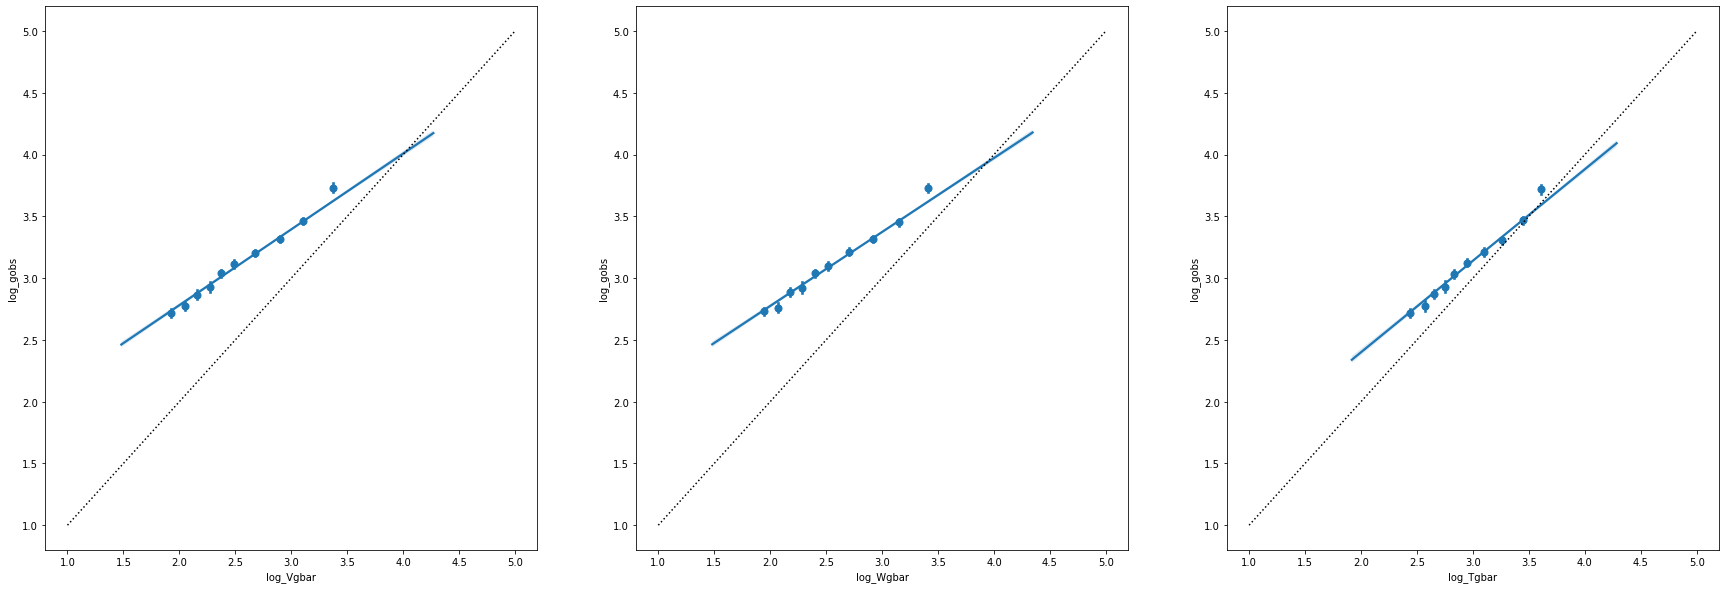

In [15]:
def plot_rar_regplot(df, line=[1,5]):
    fig, axes = plt.subplots(1, 3, figsize=(30,10))
    for i, iden in enumerate(('V', 'W', 'T')):
        x = 'log_%sgbar' % iden
        y = 'log_gobs'
        sns.regplot(data=df, x=x, y=y, order=1, ax=axes[i], x_bins=10)
        sns.lineplot(x=line, y=line, color='black', linestyle='dotted', ax=axes[i])

plot_rar_regplot(fitted)#[plot_rar_regplot(d) for d in datasets]